# 1. Introduction

# 2. Wrangling

To prepare the data for analysis, we first loaded the `players.csv` and `sessions.csv` files and inspected their structure with `glimpse()`. The players dataset contains demographics, subscription status, and total played hours for each user. Following our project plan, we removed players with `played_hours == 0`, since these users do not provide any behavioural information relevant to predicting subscription. We also excluded rows with missing values in `subscribe` or `played_hours`, and converted the categorical variables (`experience`, `gender`, `subscribe`) into factors. 

The sessions dataset required additional wrangling because its timestamps were stored as character strings. Using `separate()`, we extracted date, hour, and minute components from each start and end time, and computed a new variable `duration_min` to represent each session length. We removed sessions with zero or negative duration, then summarized each user's gameplay by calculating their number of sessions (`n_sessions`) and average session length (`mean_session_min`). These summaries were merged back into the cleaned players dataset using `left_join()`, producing the final dataset.

We then generated summary statistics and exploratory plots to understand gameplay behaviour. The distribution of played hours is highly right-skewed, with most players having less than one hour of playtime and a few players recording extremely high totals. Box-plots comparing played hours by subscription status show that subscribed players tend to have slighly higher engagement on average.

In [1]:
library(tidyverse)

players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")
glimpse(players)
glimpse(sessions)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimite

Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…
Rows: 1,535
Columns: 5
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+

In [2]:
# Wrangling - Clean players dataset
players_clean <- players |>
    filter(!is.na(subscribe), !is.na(played_hours), played_hours > 0) |>
    mutate(subscribe = factor(subscribe), gender = factor(gender), experience = factor(experience))
glimpse(players_clean)

Rows: 111
Columns: 7
$ experience   <fct> Pro, Veteran, Amateur, Regular, Amateur, Veteran, Beginne…
$ subscribe    <fct> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRU…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.7, 0.1, 0.1, 1.6, 1.5, 0.2, 48.4, 0.5, 0.6, …
$ name         <chr> "Morgan", "Christian", "Flora", "Kylie", "Natalie", "Lane…
$ gender       <fct> Male, Male, Female, Male, Male, Female, Female, Male, Fem…
$ Age          <dbl> 9, 17, 21, 21, 47, 23, 25, 22, 17, 17, 19, 58, 17, 17, 21…


In [3]:
# Wrangling - Clean sessions dataset
sessions_clean <- sessions |>
    separate(start_time, into = c("start_date", "start_clock"), sep = " ") |>
    separate(end_time, into = c("end_date", "end_clock"), sep = " ") |>
    separate(start_clock, into = c("start_hour", "start_minute"), sep = ":", convert = TRUE) |>
    separate(end_clock, into = c("end_hour", "end_minute"), sep = ":", convert = TRUE) |>
    mutate(duration_min = (end_hour - start_hour) * 60 + (end_minute - start_minute)) |>
    filter(duration_min > 0)
glimpse(sessions_clean)


Rows: 1,441
Columns: 10
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_date          <chr> "30/06/2024", "17/06/2024", "25/07/2024", "25/07/2…
$ start_hour          <int> 18, 23, 17, 3, 16, 15, 7, 2, 2, 5, 1, 15, 2, 0, 18…
$ start_minute        <int> 12, 33, 34, 22, 1, 8, 12, 13, 31, 13, 31, 15, 32, …
$ end_date            <chr> "30/06/2024", "17/06/2024", "25/07/2024", "25/07/2…
$ end_hour            <int> 18, 23, 17, 3, 16, 17, 7, 2, 2, 5, 1, 15, 3, 3, 18…
$ end_minute          <int> 24, 46, 57, 58, 12, 10, 21, 30, 49, 52, 35, 43, 12…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ duration_min        <dbl> 12, 13, 23, 36, 11, 122, 9, 17, 18, 39, 4, 28, 40,…


In [4]:
# Summarize sessions per player
sessions_summary <- sessions_clean |>
    group_by(hashedEmail) |>
    summarize(n_sessions = n(), mean_session_min = mean(duration_min))
glimpse(sessions_summary)

Rows: 124
Columns: 3
$ hashedEmail      <chr> "0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95…
$ n_sessions       <int> 1, 1, 1, 13, 2, 1, 1, 40, 1, 1, 1, 2, 1, 1, 75, 1, 1,…
$ mean_session_min <dbl> 45.000000, 30.000000, 11.000000, 32.153846, 35.000000…


In [5]:
# Join players + session summaries
players_final <- players_clean |>
    left_join(sessions_summary, by = "hashedEmail")
glimpse(players_final)

Rows: 111
Columns: 9
$ experience       <fct> Pro, Veteran, Amateur, Regular, Amateur, Veteran, Beg…
$ subscribe        <fct> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE,…
$ hashedEmail      <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee97…
$ played_hours     <dbl> 30.3, 3.8, 0.7, 0.1, 0.1, 1.6, 1.5, 0.2, 48.4, 0.5, 0…
$ name             <chr> "Morgan", "Christian", "Flora", "Kylie", "Natalie", "…
$ gender           <fct> Male, Male, Female, Male, Male, Female, Female, Male,…
$ Age              <dbl> 9, 17, 21, 21, 47, 23, 25, 22, 17, 17, 19, 58, 17, 17…
$ n_sessions       <int> 22, 3, 1, 1, 1, 3, 1, 1, 32, 2, 2, 1, 1, 2, 1, 1, NA,…
$ mean_session_min <dbl> 58.63636, 85.00000, 50.00000, 9.00000, 13.00000, 38.3…


In [6]:
# Summary stats

# Overall
players_final |>
    summarize(
        mean_hours = mean(played_hours),
        median_hours = median(played_hours),
        sd_hours = sd(played_hours),
        subscription_rate = mean(subscribe == "TRUE"))

# Subscription rate by experience
players_final |>
    group_by(experience) |>
    summarize(subscription_rate = mean(subscribe == "TRUE"))

# Subscription rate by gender
players_final |>
    group_by(gender) |>
    summarize(subscription_rate = mean(subscribe == "TRUE"))

mean_hours,median_hours,sd_hours,subscription_rate
<dbl>,<dbl>,<dbl>,<dbl>
10.32252,0.5,37.1334,0.7747748


experience,subscription_rate
<fct>,<dbl>
Amateur,0.8000000
Beginner,0.7894737
Pro,0.7272727
Regular,0.9000000
Veteran,0.6538462


gender,subscription_rate
<fct>,<dbl>
Agender,1.0000000
Female,0.7619048
Male,0.7733333
Non-binary,0.8333333
Other,1.0000000
Prefer not to say,0.6000000
Two-Spirited,1.0000000


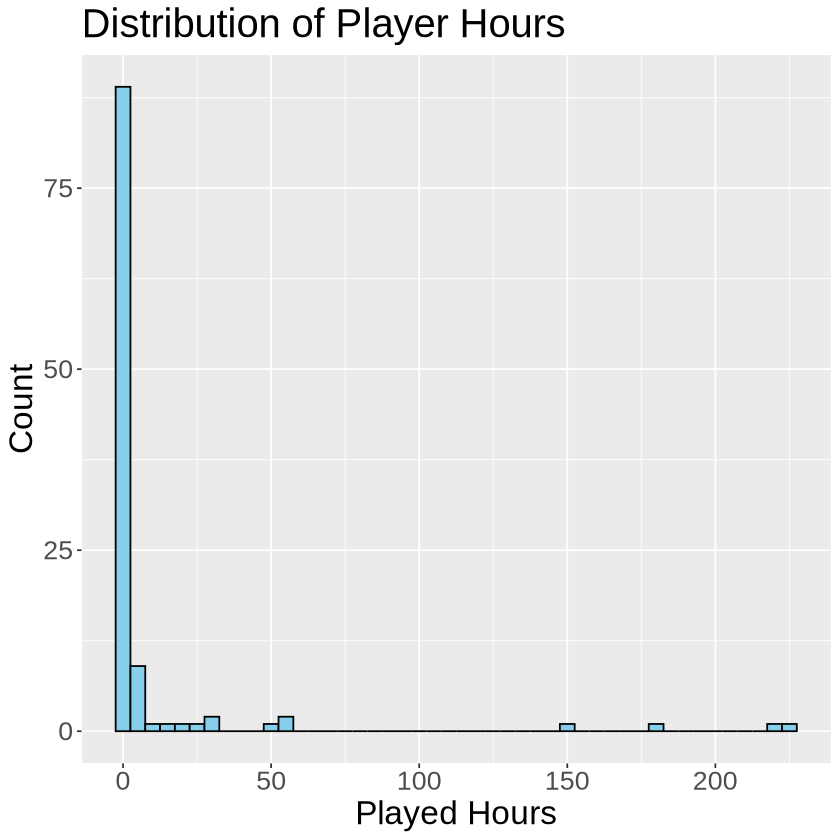

In [7]:
options(repr.plot_height = 20, repr.plot_width = 20)
ggplot(players_final, aes(x = played_hours)) +
    geom_histogram(binwidth = 5, fill = "skyblue", color = "black") +
    labs(x = "Played Hours", y = "Count", title = "Distribution of Player Hours") +
    theme(text = element_text(size = 20))

**Figure 1.** Distribution of played hours (full scale). This histogram shows that the distribution is extremely right-skewed, which a few players recording very high totals. 

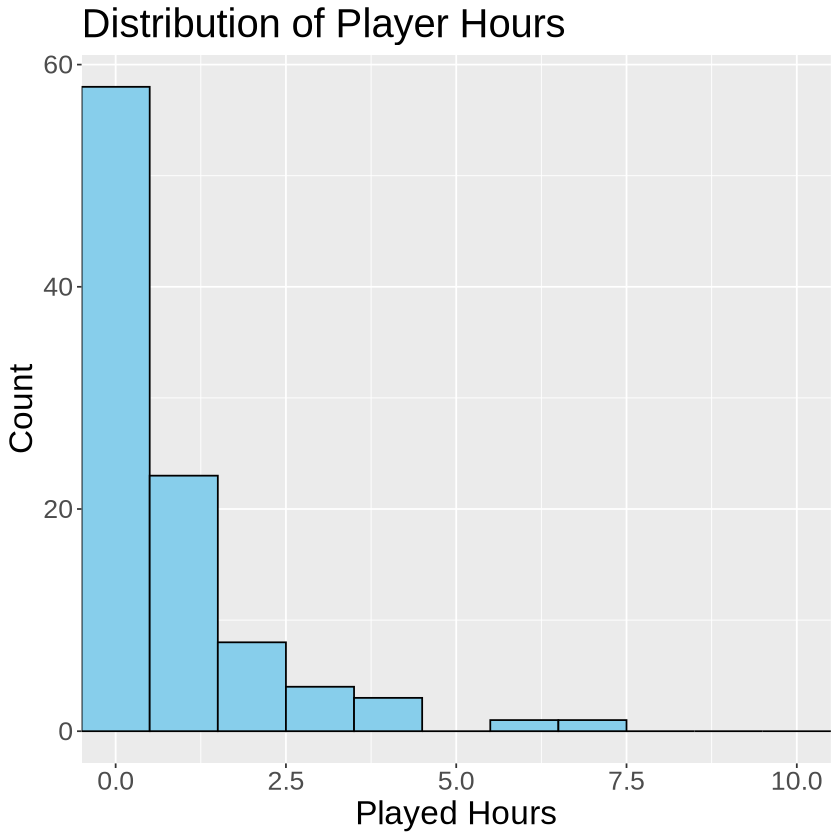

In [8]:
options(repr.plot_height = 20, repr.plot_width = 20)
ggplot(players_final, aes(x = played_hours)) +
    geom_histogram(binwidth = 1, fill = "skyblue", color = "black") +
    coord_cartesian(xlim = c(0, 10)) +
    labs(x = "Played Hours", y = "Count", title = "Distribution of Player Hours") +
    theme(text = element_text(size = 20))

**Figure 2.** Distribution of played hours (0-10 hours). Zooming in on the lower range shows that most players have played under two hours. 

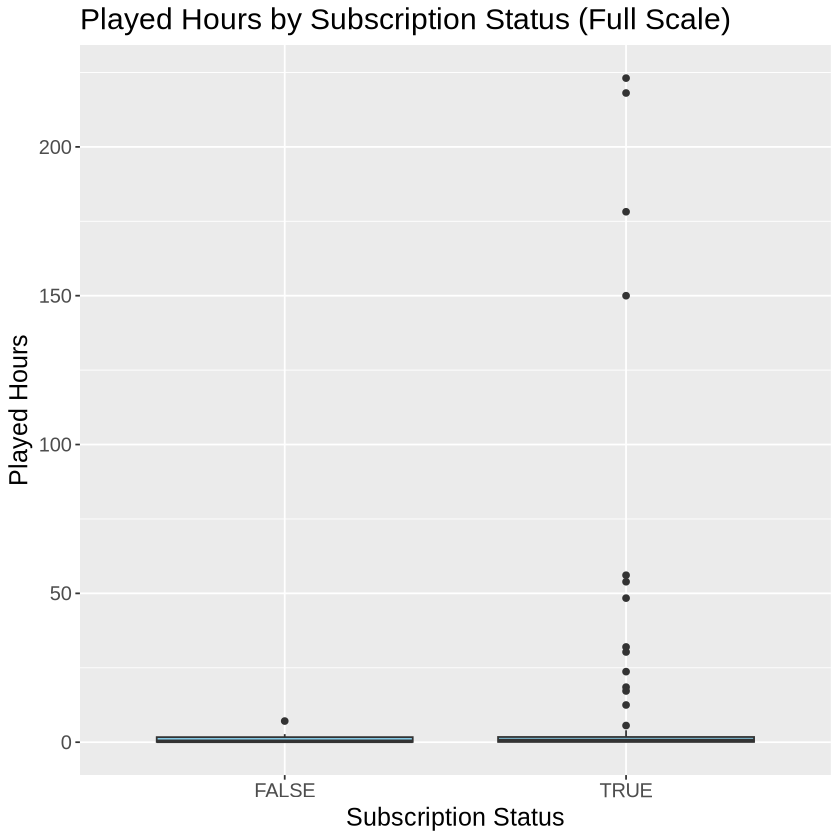

In [9]:
ggplot(players_final, aes(x = subscribe, y = played_hours)) +
    geom_boxplot(fill = "skyblue") +
    labs(x = "Subscription Status", y = "Played Hours", title = "Played Hours by Subscription Status (Full Scale)") +
    theme(text = element_text(size = 15))

**Figure 3.** Boxplot of played hours by subscription status (full scale). Subscribed players tend to show slightly higher engagement.

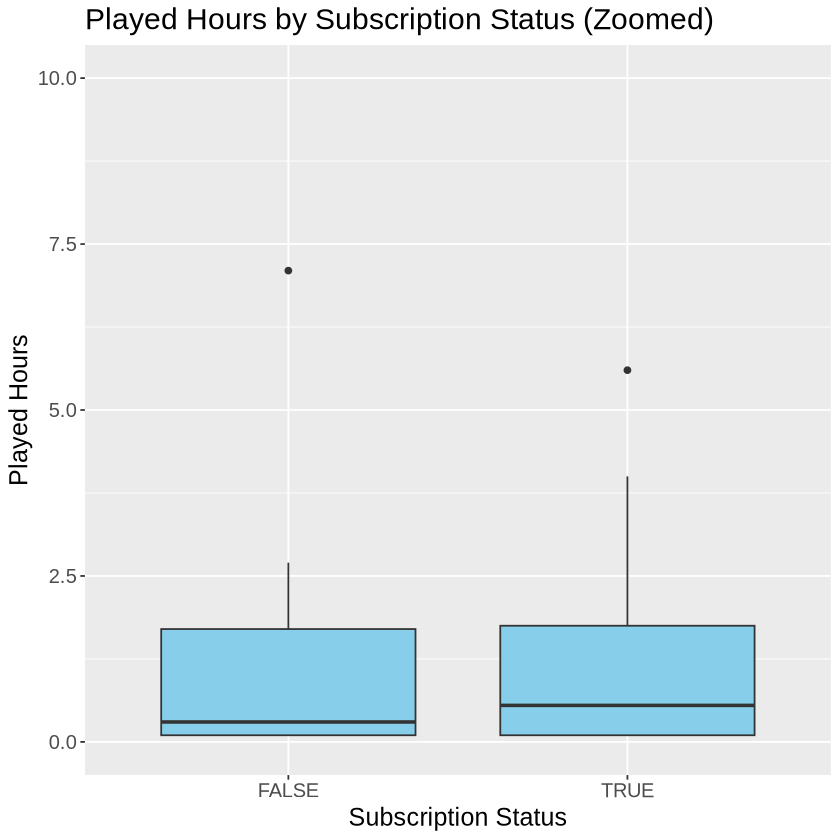

In [10]:
ggplot(players_final, aes(x = subscribe, y = played_hours)) +
    geom_boxplot(fill = "skyblue") +
    coord_cartesian(ylim = c(0, 10)) +
    labs(x = "Subscription Status", y = "Played Hours", title = "Played Hours by Subscription Status (Zoomed)") +
    theme(text = element_text(size = 15))

**Figure 4.** Boxplot of played hours by subscription status, zoomed to 0-10 hours for clarity. This highlights that most players play very little. 

These cleaned and summarized data will be used by the modeling section to fit logistic regression models predicting subscription from gameplay behaviour and demographic variables. 

# 3. Dealing With Visualizations

# 4. Data Analysis

# 5. Discussion